<a href="https://colab.research.google.com/github/PalmerTurley34/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=.8, test_size=.2,
                              stratify=train['status_group'])

In [0]:
# function to wrangle data
import numpy as np
def wrangle(x):
  x = x.copy()
  x['latitude']=x['latitude'].replace(-2e-08, 0)
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'gps_height', 'population']
  for col in cols_with_zeros:
    x[col] = x[col].replace(0, np.nan)
    x[col+'_Missing'] = x[col].isnull()

    duplicates = ['quantity_group', 'payment_type']
    unusable_variance = ['recorded_by', 'id']
    x = x.drop(columns=duplicates + unusable_variance)

    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x['day_recorded'] = x['date_recorded'].dt.day
    x = x.drop(columns = 'date_recorded')

    x['years'] = x['year_recorded'] - x['construction_year']
    x['years_Missing'] = x['years'].isnull()

    return x

In [0]:
# wrangle data
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# features matrix and target vector
target = 'status_group'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
# pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1)
)

In [19]:
# fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
pipeline.score(X_val, y_val)

0.8087542087542088

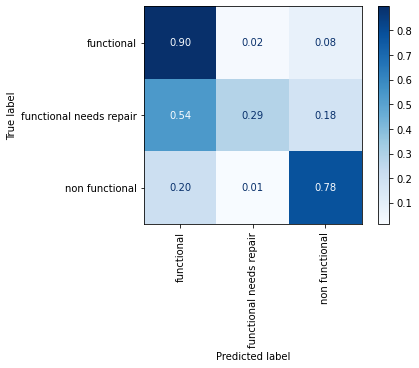

In [20]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation='vertical',
                      values_format='.2f', cmap='Blues', normalize='true')

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.55      0.29      0.38       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



In [26]:
print(pipeline.predict_proba(X_val))

[[6.22533333e-01 5.04000000e-02 3.27066667e-01]
 [6.96071682e-01 1.92085389e-01 1.11842929e-01]
 [8.37603738e-01 8.10478007e-02 8.13484614e-02]
 ...
 [9.96139568e-01 7.34545709e-04 3.12588674e-03]
 [4.11562818e-02 1.63934426e-04 9.58679784e-01]
 [1.13333333e-01 1.16666667e-02 8.75000000e-01]]


In [27]:
pipeline.predict(X_val)

array(['functional', 'functional', 'functional', ..., 'functional',
       'non functional', 'non functional'], dtype=object)